In [123]:
import sys
import os
import math

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

from tqdm import tqdm

import concatenate
import plot
import regression as reg
import bootstrap as boot

In [124]:
def readfile(path):
    output = np.loadtxt(f'{path}/analysis/Wloop.dat', skiprows=1)
    columns = [output[:, i] for i in range(output.shape[1])]

    return np.column_stack(columns)

def format(y, d_y, digits=2):
    '''
    correct formatting for displaying result(uncertainty).
    '''
    d_digits = int(math.floor(math.log10(abs(d_y))))
    d_y_rounded = round(d_y, -d_digits + (digits - 1))

    decimal_places = -d_digits + (digits - 1)

    value_rounded = round(y, decimal_places)

    formatted = f"{value_rounded:.{decimal_places}f}({int(d_y_rounded * 10**decimal_places):0{digits}d})"
    print(formatted)

def boot_fit(x, y, d_y, b_y, model, lim_inf, lim_sup, extension=None):
    '''
    bootstrapping the fit to account for cross-correlation.
    '''
    x_fit, y_fit, d_y_fit, b_y_fit = x[lim_inf:lim_sup], y[lim_inf:lim_sup], d_y[lim_inf:lim_sup], b_y[lim_inf:lim_sup]
    opt, cov = curve_fit(model, x_fit, y_fit, sigma=d_y_fit, absolute_sigma=True)
    
    n_boot = len(b_y[0])

    x_linsp = np.linspace(x_fit[0], x_fit[-1], 100)
    if extension:
        x_linsp=np.linspace(extension[0], extension[1], extension[2])
        
    y_linsp = model(x_linsp, *opt)
        
    b_opt = []
    ## b_c2r = []
    b_y_linsp = []
    
    for j in range(n_boot):
        y_fit_j = [b_y_fit[i][j] for i in range(len(b_y_fit))]
        
        opt_j, cov_j = curve_fit(model, x_fit, y_fit_j, sigma=d_y_fit, absolute_sigma=True)
        b_opt.append(opt_j)

        ## b_c2r.append(reg.chi2_corr(x_fit, y_fit_j, model, np.diag(np.array(d_y_fit)**2), *opt_j))
        
        y_linsp_j = model(x_linsp, *opt_j)
        b_y_linsp.append(y_linsp_j)

    d_opt = np.std(b_opt, axis=0, ddof=1)
    
    c2r = reg.chi2_corr(x_fit, y_fit, model, np.diag(np.array(d_y_fit)**2), *opt)
    ## d_c2r = np.std(b_c2r)
    
    d_y_linsp = np.std(b_y_linsp, axis=0, ddof=1)
    return x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r   

def quadratic(x,a,b,c):
    return a + b*x +c*x**2

In [125]:
def tune_r2F(input_dir, beta_lst, rLi_lst, *, flag=0, use_exact_force = False):
    def zeros(x):
        return (quadratic(x,*opt) - y_0)

    tuned_betas = []
    
    plt.figure(figsize=(18,12))
    for i, rLi in enumerate(rLi_lst):
        y_lst, d_y_lst, b_y_lst = [], [], []
        
        for beta in beta_lst[i]:
            path =  f'{input_dir}/Nt42_Ns42_b{beta}'
            if use_exact_force:
                tmp = np.load(f"{path}/analysis/force_r2F_{int(rLi[0]**2)}_{int(rLi[1]**2)}.npy", allow_pickle=True)
            else:
                tmp = np.load(f"{path}/analysis/r2F_{int(rLi[0]**2)}_{int(rLi[1]**2)}.npy", allow_pickle=True)

            r2F, b_r2F = tmp[0], tmp[1]
            
            y_tmp, b_y_tmp = r2F[flag], b_r2F[flag]
                                                
            d_y_tmp = np.std(b_y_tmp, ddof=1) 
                    
            label = fr'$r^{{({i+1})}}_1$ = {rLi[0]:.2f}' if beta == beta_lst[i][0] else None
            plt.errorbar(beta, y_tmp, d_y_tmp, **plot.data(i), label=label)
                       
            y_lst.append(y_tmp)
            d_y_lst.append(d_y_tmp)
            b_y_lst.append(b_y_tmp)
        
            if i==0 and beta==beta_lst[i][0]:
                beta_0 = beta
                y_0 = y_tmp
        if i!=0:
            x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r = boot_fit(x=beta_lst[i], y=y_lst, d_y=d_y_lst, b_y=b_y_lst, model=quadratic, lim_inf=0, lim_sup=len(y_lst))
            plt.plot(x_linsp, y_linsp, **plot.fit(i))
            plt.fill_between(x_linsp, y_linsp-d_y_linsp, y_linsp+d_y_linsp, **plot.conf_band(i))
        
            ## finding which value of the bare coupling corresponds to the same physical coupling
            beta_tuned = fsolve(zeros, beta_0)
        
            tuned_betas.append(beta_tuned)
        
            x_tuned = np.array(tuned_betas)[i-1]
            y_tuned = quadratic(x_tuned,*opt)
            b_y_tuned = [quadratic(x_tuned, *opt_j) for opt_j in b_opt]
            d_y_tuned = np.std(b_y_tuned, ddof=1)
            plt.errorbar(x_tuned, y_tuned, d_y_tuned, **plot.data(0))
    
    plt.xlabel(fr'$\beta=1/g^2$')
    plt.ylabel(fr'$r_1^2F(r_{flag+1}/a,g)$')
    plt.legend()
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    if (use_exact_force):
        plt.savefig(f'{input_dir}/force_r2F_r{flag+1}.png', dpi=300, bbox_inches='tight')
    else:
        plt.savefig(f'{input_dir}/r2F_r{flag+1}.png', dpi=300, bbox_inches='tight')

    plt.show()
    
    return tuned_betas

#### Given a set of $\{\beta^{(j)}\}$ for each of the distances $r^{(j)}_i$, with $i\in\{1,2\}$ indicating which of the two values $\overline{g}^2(r_i)$, needs to be tuned and $(j)$ indicating the different scales (i.e. the different sets of distances for which the running coupling has been computed), find the values of the bare coupling such that $(\overline{g}^{2})^{(j)}(r_i)$ is constant $\forall j$.

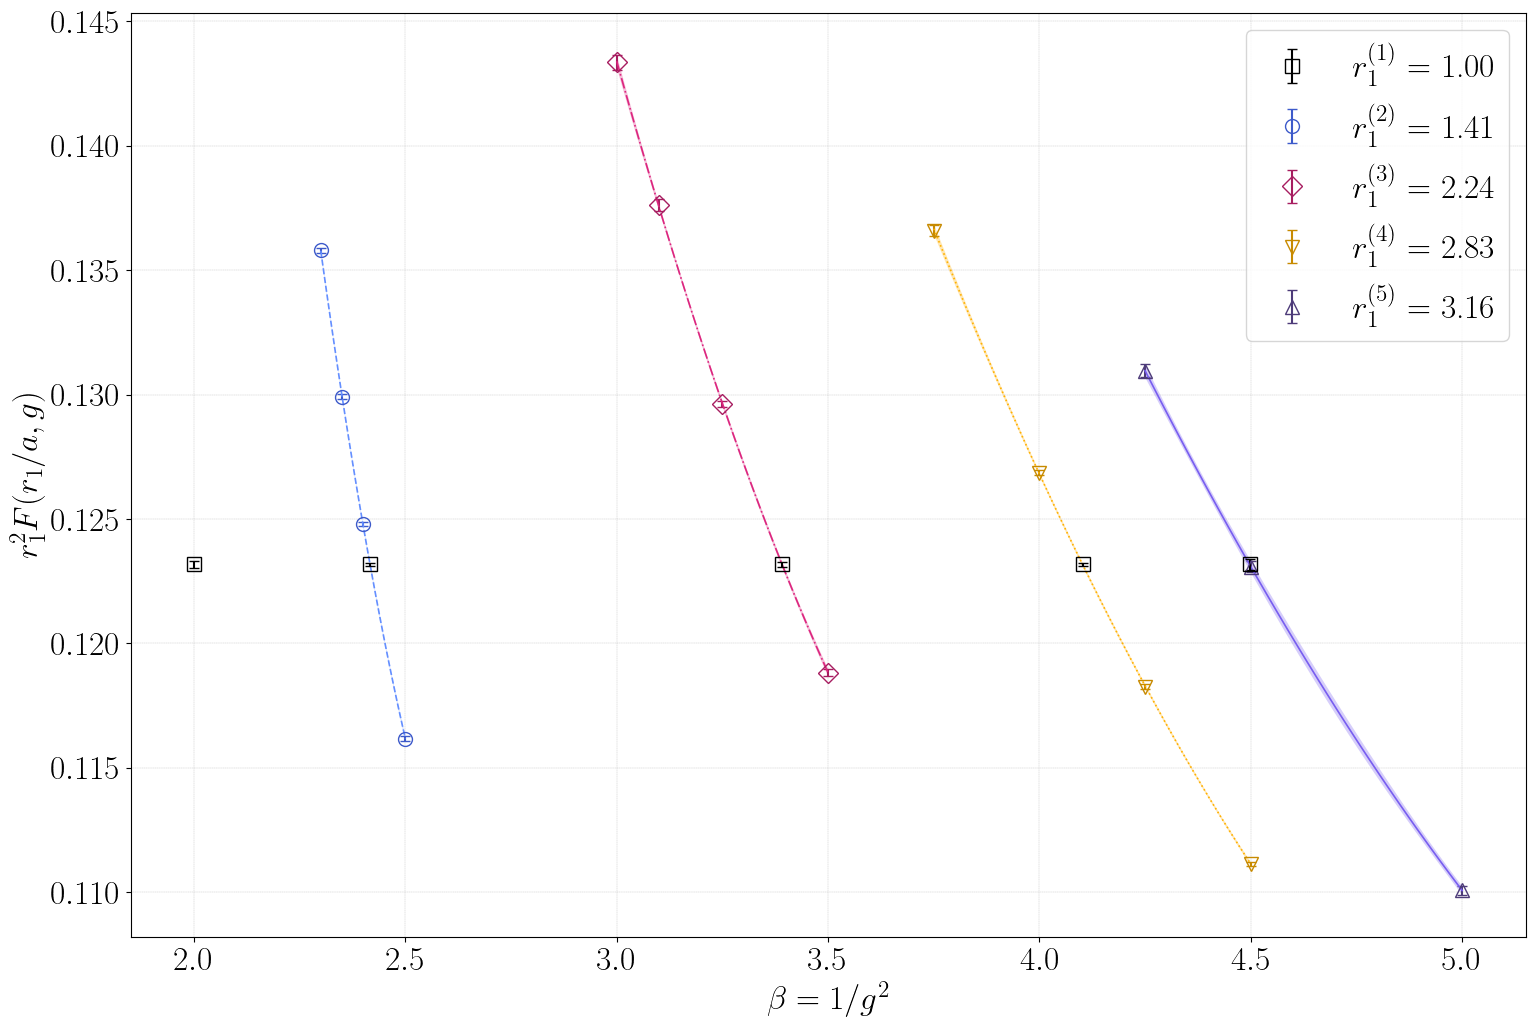

In [126]:
input_dir = '/home/negro/projects/matching/step_scaling/infinite_volume_scheme_PBC'

## use the exact definition of the force or the finite difference
use_exact_force = True

## list of betas available
beta_0 = [2]
if use_exact_force:
    beta_lst_1 = [2.3, 2.35, 2.4, 2.5]
    beta_lst_2 = [3, 3.1, 3.25, 3.5]
    beta_lst_3 = [3.75, 4, 4.25, 4.5]
    # beta_lst_4 = [4.25, 4.5, 5]
    beta_lst_5 = [4.25, 4.5, 5]
else:
    beta_lst_1 = [2.25, 2.3, 2.35, 2.4]
    beta_lst_2 = [2.8, 2.9, 3, 3.1]
    beta_lst_3 = [3.25, 3.5, 3.75, 4]


beta_lst = [beta_0, beta_lst_1, beta_lst_2, beta_lst_3, beta_lst_5]

## different distances used
rL3 = np.array([1, 5, 8])**0.5
rL4 = np.array([2, 10, 18])**0.5
rL5 = np.array([5, 25, 32])**0.5
rL7 = np.array([8, 40, 72])**0.5
rL8 = np.array([9, 45, 98])**0.5
rL9 = np.array([10, 50, 128])**0.5


## distances to be used at the present moment
rLi_lst = [rL3, rL4, rL5, rL7, rL9]

## flag=0 -> r1, flag=1 -> r2 
tuned_betas = tune_r2F(input_dir, beta_lst, rLi_lst, flag=0, use_exact_force=use_exact_force)

In [127]:
def colim_vs_beta(input_dir, beta_lst, rLi_lst, tuned_betas, *, flag=1, use_exact_force=False):
    res, d_res, b_res = [], [], []

    plt.figure(figsize=(18,12))  
    for i, rLi in enumerate(rLi_lst):
        y_lst, d_y_lst, b_y_lst = [], [], []
        
        for beta in beta_lst[i]:
            path =  f'{input_dir}/Nt42_Ns42_b{beta}'

            if use_exact_force:
                tmp = np.load(f"{path}/analysis/force_r2F_{int(rLi[0]**2)}_{int(rLi[1]**2)}.npy", allow_pickle=True)
            else:
                tmp = np.load(f"{path}/analysis/r2F_{int(rLi[0]**2)}_{int(rLi[1]**2)}.npy", allow_pickle=True)
            r2F, b_r2F = tmp[0], tmp[1]
            
            y_tmp = r2F[flag]
            b_y_tmp = b_r2F[flag]
            d_y_tmp = np.std(b_y_tmp, ddof=1)
            
            label=fr'$r^{{({i+1})}}_2$={rLi[1]:.2f}' if beta==beta_lst[i][0] else None
            plt.errorbar(beta, y_tmp, d_y_tmp, **plot.data(i), label=label)

            y_lst.append(y_tmp)
            d_y_lst.append(d_y_tmp)
            b_y_lst.append(b_y_tmp)
        
            if i==0 and beta==beta_lst[i][0]:
                res.append(y_tmp)
                d_res.append(d_y_tmp)
                b_res.append(b_y_tmp)

        if i!=0:
            x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r = boot_fit(x=beta_lst[i], y=y_lst, d_y=d_y_lst, b_y=b_y_lst, model=quadratic, lim_inf=0, lim_sup=len(y_lst))
            
            plt.plot(x_linsp, y_linsp, **plot.fit(i))
            plt.fill_between(x_linsp, y_linsp-d_y_linsp, y_linsp+d_y_linsp, **plot.conf_band(i))
            
            x_tuned = tuned_betas[i-1]
            y_tuned = quadratic(x_tuned,*opt)
            b_y_tuned = [quadratic(x_tuned, *opt_j) for opt_j in b_opt]
            d_y_tuned = np.std(b_y_tuned, ddof=1)
            plt.errorbar(x_tuned, y_tuned, d_y_tuned, **plot.data(0))
            
            res.append(np.float64(y_tuned[0]))
            d_res.append(np.float64(d_y_tuned))
            b_res.append(b_y_tuned)
                
    plt.ylabel(fr'$r_2^2F(r_{flag+1}/a,g)$')
    plt.xlabel(fr'$\beta=1/g^2$')
    plt.legend(loc='lower left')
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    
    if use_exact_force:
        plt.savefig(f'{input_dir}/force_r2F_r{flag+1}.png', dpi=300, bbox_inches='tight')
    else:
        plt.savefig(f'{input_dir}/r2F_r{flag+1}.png', dpi=300, bbox_inches='tight')
   
    plt.show()
    
    b_res = [[np.float64(np.squeeze(x)) for x in row] for row in b_res]
    b_res = np.array(b_res)
    
    return res, d_res, b_res

In [128]:
def colim_vs_rlatt(r_latt, res, d_res, b_res, flag=1, use_exact_force=False):
    x_fit = np.array(1/r_latt)
    
    plt.figure(figsize=(18,12))
    plt.xlim(left=0, right=0.5)
    plt.ylim(bottom=0.15, top = 0.4)
    plt.errorbar(x_fit, res, d_res, **plot.data(0))
    
    # def model(x, a, b, c):
    #     return a + b*x**2 + c*x**4
    
    # x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r = boot_fit(x=x_fit, y=res, d_y=d_res, b_y=b_res, model=model, lim_inf=0, lim_sup=len(res), extension=[0, x_fit[0], 51])

    # plt.plot(x_linsp, y_linsp, **plot.fit(2))
    # plt.fill_between(x_linsp, y_linsp-d_y_linsp, y_linsp+d_y_linsp, **plot.conf_band(2))
    
    plt.xlabel(r'$1/r_{latt}$')
    plt.ylabel(fr'$r_2^2F(r_{flag+1}/a,g)$')
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    if use_exact_force:
        plt.savefig(f"/home/negro/projects/matching/step_scaling/infinite_volume_scheme_PBC/force_continuum_limit_rlatt", dpi=300, bbox_inches='tight')
    else:
        plt.savefig(f"/home/negro/projects/matching/step_scaling/infinite_volume_scheme_PBC/continuum_limit_rlatt", dpi=300, bbox_inches='tight')

    plt.show()

In [140]:
def colim_vs_r2latt(r_latt, res, d_res, b_res, flag=1, use_exact_force=False, ):
    x_fit = np.array(1/r_latt)**2
    
    plt.figure(figsize=(18,12))
    plt.xlim(left=0, right=0.21)
    plt.ylim(bottom=0.15, top = 0.4)
    plt.errorbar(x_fit, res, d_res, **plot.data(0))
    
    
    def model(x, a, b,c):
        return a + b*x + c*x**2
        
    x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r = boot_fit(x=x_fit, y=res, d_y=d_res, b_y=b_res, model=model, lim_inf=0, lim_sup=len(res), extension=[0, x_fit[0], 51])

    plt.plot(x_linsp, y_linsp, **plot.fit(2))
    plt.fill_between(x_linsp, y_linsp-d_y_linsp, y_linsp+d_y_linsp, **plot.conf_band(2))
    
    plt.title(f'c2r={c2r:.4f}\n opt={opt}\n d_opt={d_opt}')
    
    plt.xlabel(r'$1/r^{2}_{latt}$')
    plt.ylabel(fr'$r_2^2F(r_{flag+1}/a,g)$')
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    if use_exact_force:
        plt.savefig(f"/home/negro/projects/matching/step_scaling/infinite_volume_scheme_PBC/force_continuum_limit_r2latt", dpi=300, bbox_inches='tight')
    else:
        plt.savefig(f"/home/negro/projects/matching/step_scaling/infinite_volume_scheme_PBC/continuum_limit_r2latt", dpi=300, bbox_inches='tight')
    plt.show()

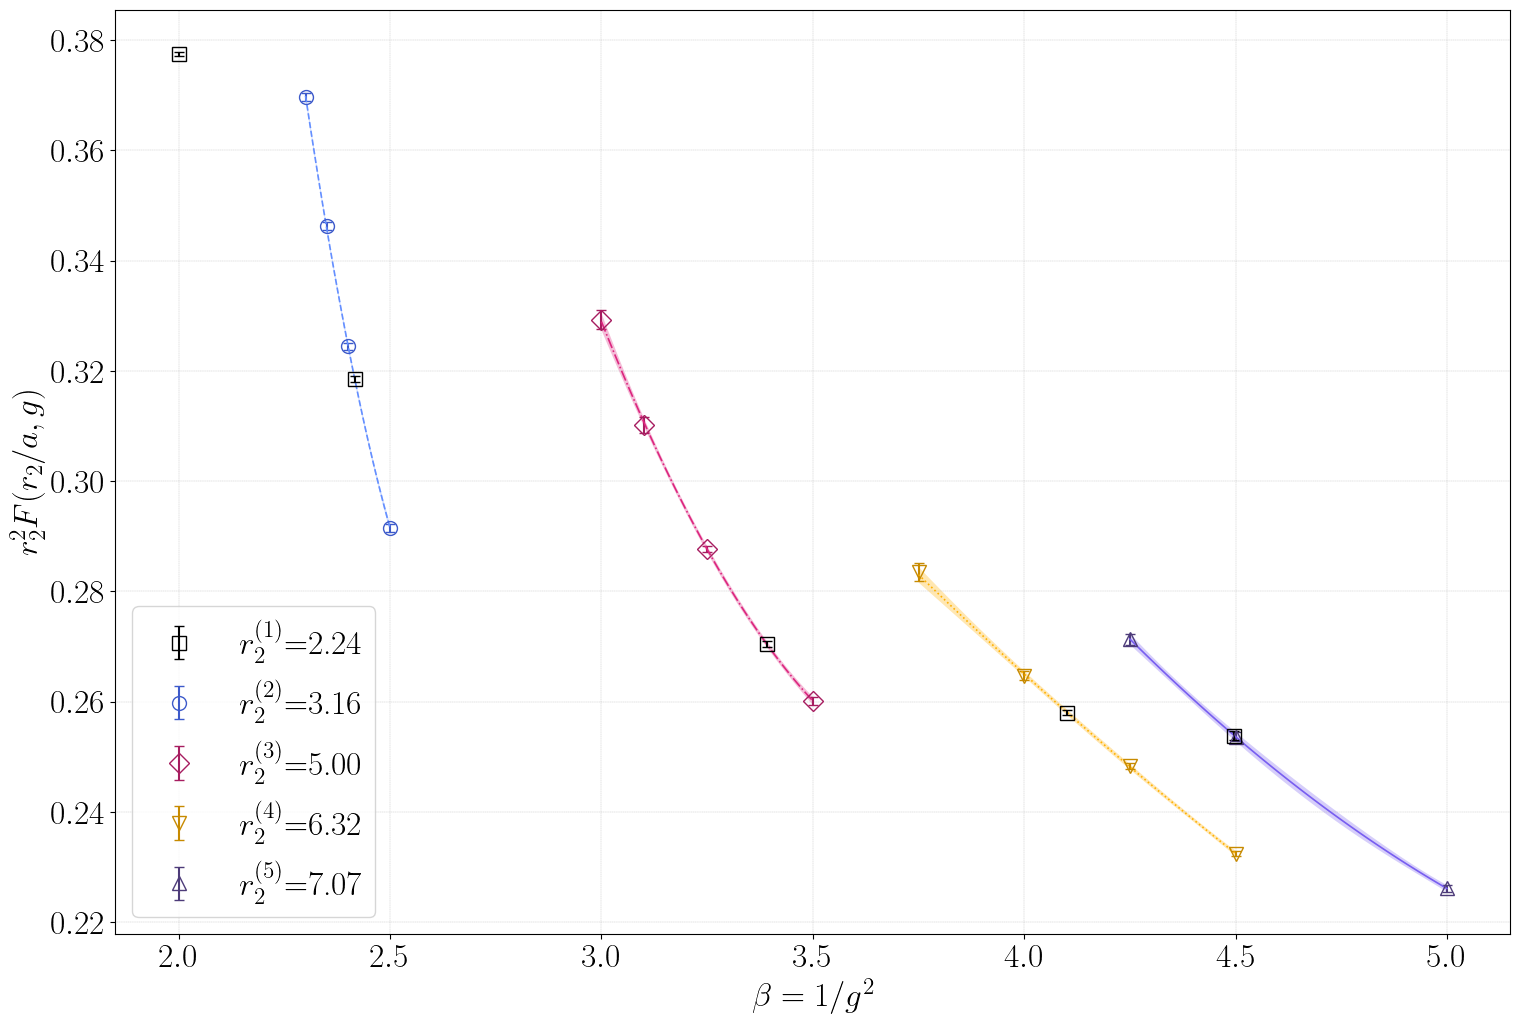

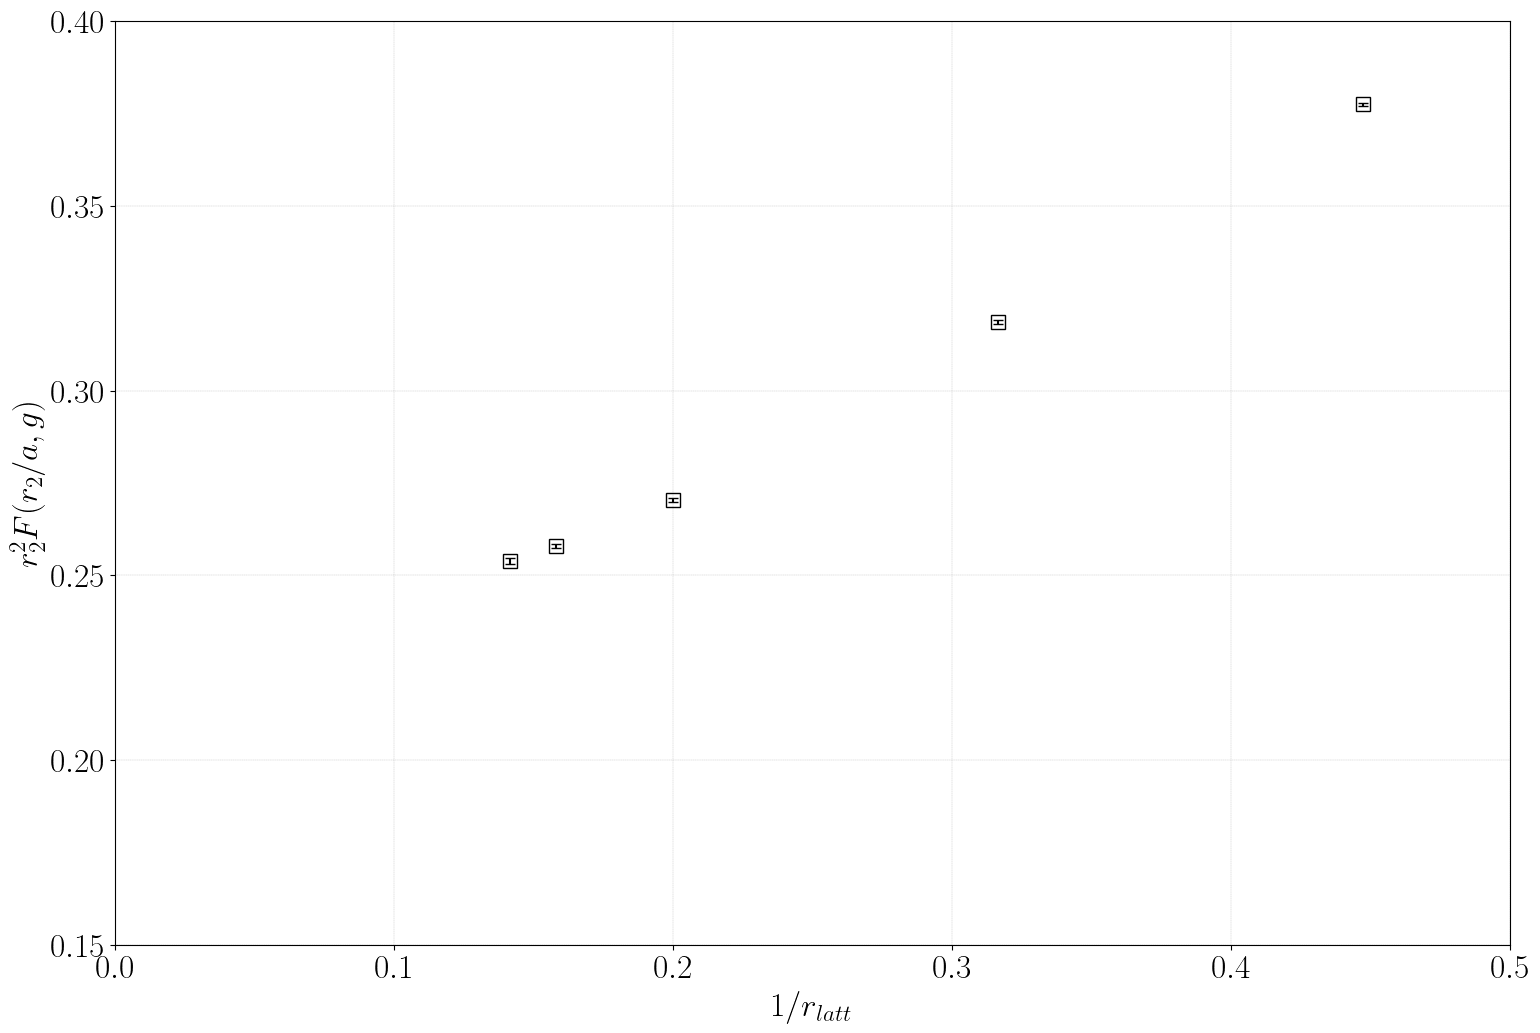

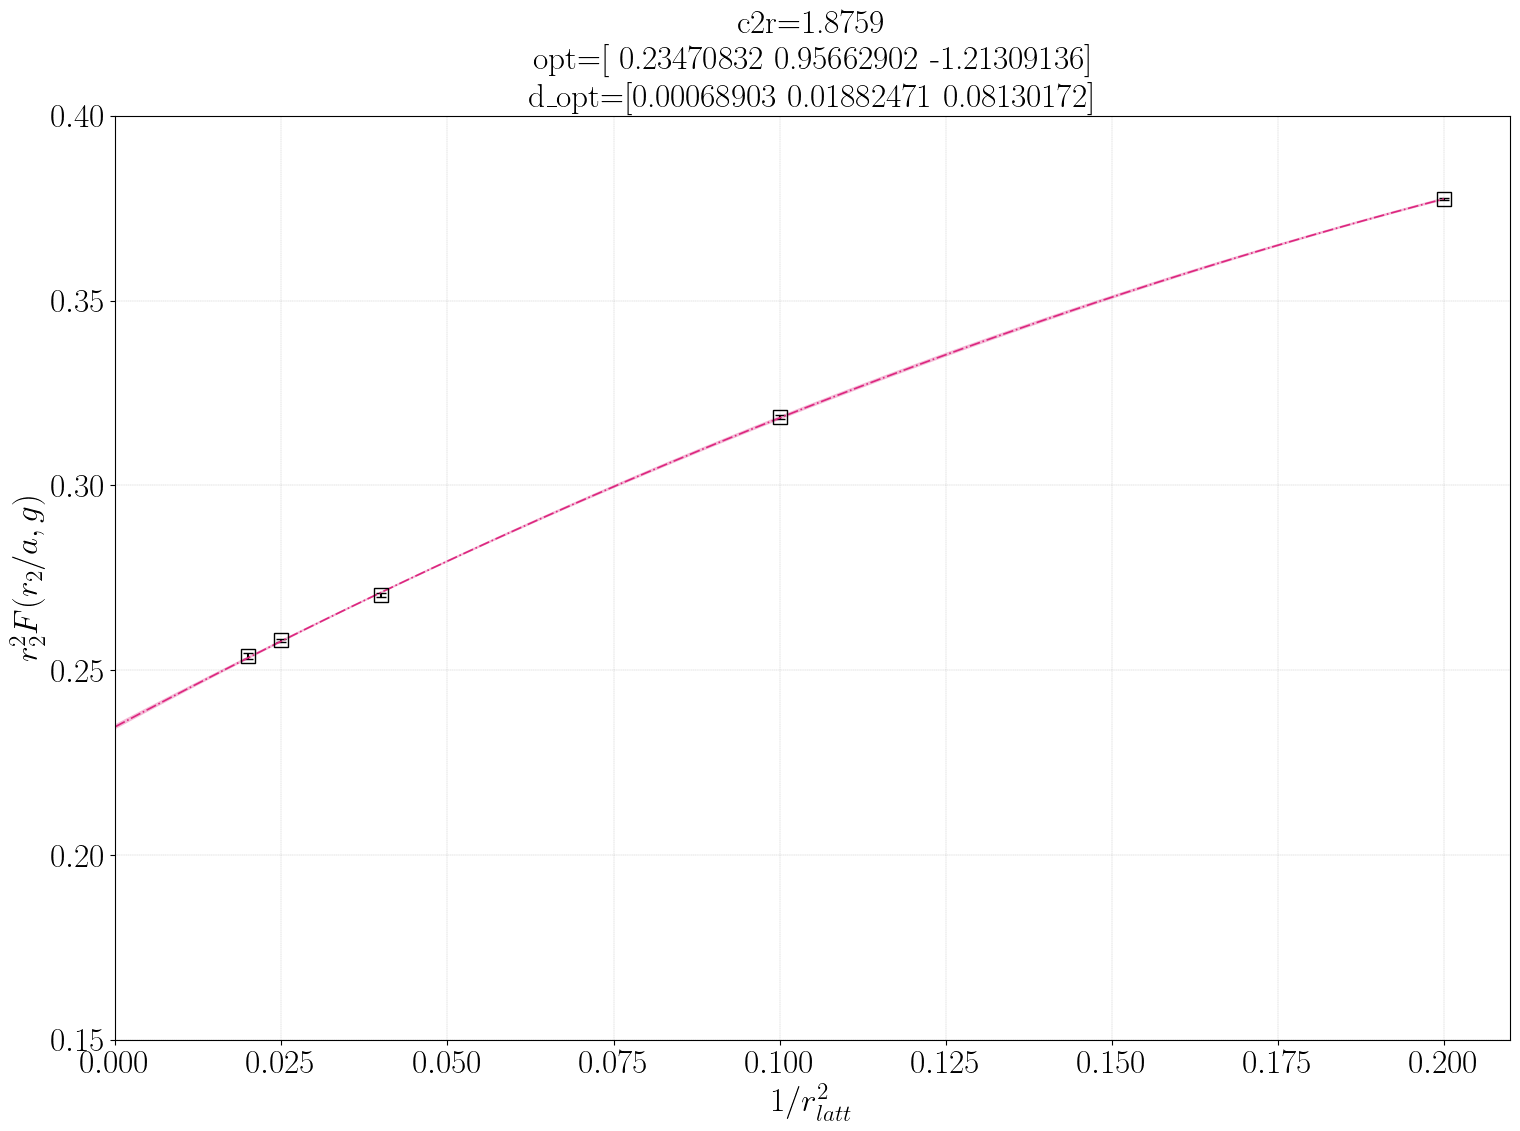

In [141]:
res, d_res, b_res = colim_vs_beta(input_dir, beta_lst, rLi_lst, tuned_betas, flag=1, use_exact_force=True)

r_latt = np.array([5, 10, 25, 40, 50])**0.5

colim_vs_rlatt(r_latt, res, d_res, b_res, flag=1, use_exact_force=True)

colim_vs_r2latt(r_latt, res, d_res, b_res, flag=1, use_exact_force=True)